# **Exercise 2: data visualization & clustering**

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 13

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time

from sklearn.neighbors import NearestNeighbors

## Data and labels 
In this example we know the labels, hence we can test the performances of t-SNE and DBSCAN

In [4]:
# file names
fname,fnamey="x_12d.dat","y_12d.dat"

# data
data=np.loadtxt("DATA/"+fname, delimiter='\t')
x=data

# labels
y=np.loadtxt("DATA/"+fnamey,dtype=int)
lab, num = np.unique(y, return_counts=True)
print('Classes:', lab)
print('Samples in each class:', num)

# data dimension
N=len(data)
D=len(data[0])

print()
print('Data dimension:')
print("N =",N,"  L = D = ",D)

Classes: [0 1 2]
Samples in each class: [229 247 124]

Data dimension:
N = 600   L = D =  12


## Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps"

mean minimum distance between points: 162.35


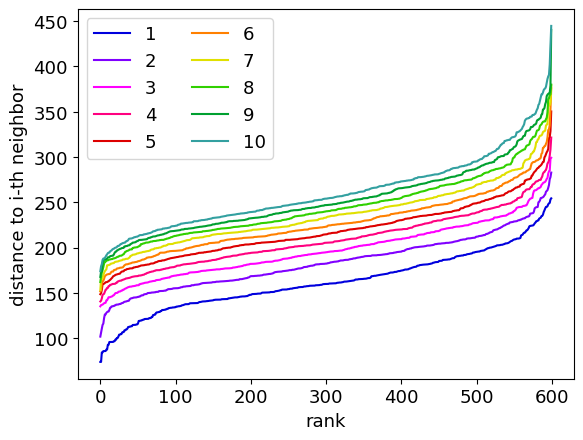

In [5]:
# number of nearest neighbors
nn = 10

# fitting the algorithm on our data
nbrs = NearestNeighbors(n_neighbors=nn+1).fit(x) #, algorithm='ball_tree'

# retrieving distances matrix for every point from every i-th neighbor
d, ind = nbrs.kneighbors(x)
# transposing the distances matrix
# note: dd[0] has a trivial set of zeros
dd=d.T

# colors for the plot
listc= ["#0000DD","#8000FF","#FF00FF","#FF0080","#DD0000",
        "#FF8000","#E0E000","#30D000","#00A030","#33A0A0"]

# mean distance of the first neighbor
mean_min_dist = np.mean(dd[1])
print(f"mean minimum distance between points: {mean_min_dist:.2f}")

# visualization of the ranked distance
for i in range(1,nn+1):
    plt.plot(np.sort(dd[i]),c=listc[i-1],label=str(i))
    plt.xlabel("rank")
    plt.ylabel("distance to i-th neighbor")
plt.legend(ncol=2)
plt.show()

## t-SNE visualization, for true labels

Time for the fit with perplexity = 2: 2.20 s
Time for the fit with perplexity = 4: 1.85 s
Time for the fit with perplexity = 8: 1.78 s
Time for the fit with perplexity = 16: 1.98 s
Time for the fit with perplexity = 32: 2.20 s


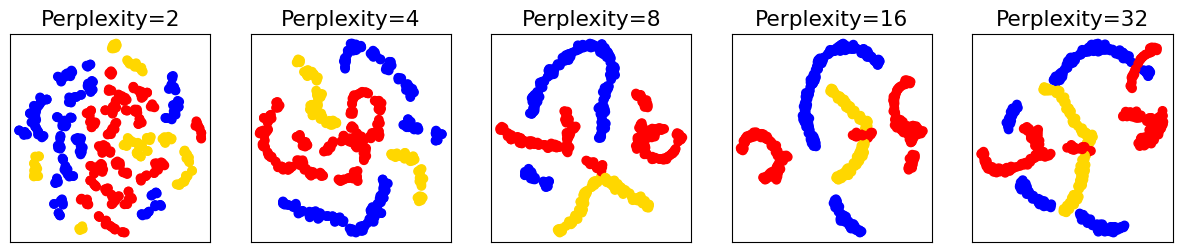

In [6]:
np.random.seed(0)

# dataset dimension
n_samples = N

# visualization on the plane
n_components = 2 

# perplexity parameters
perplexities = [2, 4, 8, 16, 32]
Np = len(perplexities)

# colors
mycmap = ListedColormap(["blue","red","gold" ])

# visualization with different perplexities
(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

# list to store low dimensional data
X_all = [None]

# plots
for i, perplexity in enumerate(perplexities):
    ax = subplots[i]
    # calculating time for the fit
    t0 = time()
    # embedding
    tsne = manifold.TSNE(n_components=n_components, 
                         init='random',
                         random_state=0, # same random state for all perplexities
                         perplexity=perplexity)
    # retrieving transformed data in low-dimensional space
    Y = tsne.fit_transform(data)
    t1 = time()
    print(f'Time for the fit with perplexity = {perplexity}: {t1-t0:.2f} s' )

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

## Different random initial states (random_state=i)

Time for the fit with perplexity = 8: 1.51 s
Time for the fit with perplexity = 8: 1.54 s
Time for the fit with perplexity = 8: 1.64 s
Time for the fit with perplexity = 8: 2.20 s
Time for the fit with perplexity = 8: 1.42 s


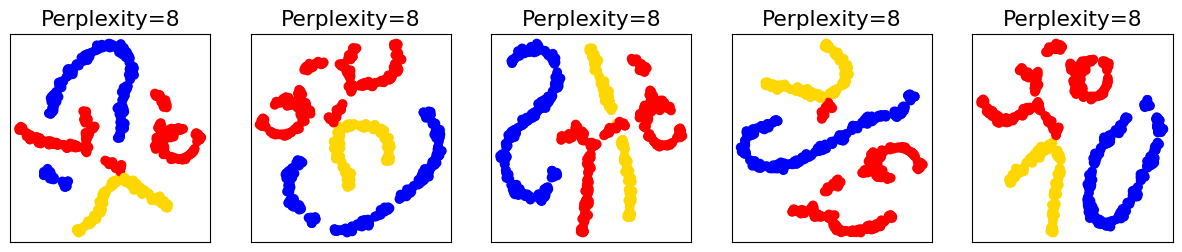

In [7]:
# visualization with different random initial states

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

# list to store low dimensional data
X_all = [None]

# fixed perplexity
perplexity= 8

for i in range(5):
    np.random.seed(i) 
    ax = subplots[i]
    # calculating time for the fit
    t0 = time()
    # embedding
    tsne = manifold.TSNE(n_components=n_components, 
                         init='random',
                         random_state=i, # different random state
                         perplexity=perplexity)
    # retrieving transformed data in low-dimensional space
    Y = tsne.fit_transform(data)
    t1 = time()
    print(f'Time for the fit with perplexity = {perplexity}: {t1-t0:.2f} s' )
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

## DBSCAN: find labels by applying clustering

In [8]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict

In [9]:
# colors
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]

In [10]:
def clustering(y): # arg : labelled data 
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    # Function that return a dictionary with: (label of the cluster  -  indices of the data (y) in that specific cluster)
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()   # initializing dictionary
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]    # fill the dictionary
    return clustering

def entropy(c, n_sample):   # c = dictionary (clusters) 
                            # n_sample = total number of sample
    # Measures the entropy of a cluster
    # if the density is well distributed among the clusters 
    # then the entropy of the clustering system is low 
    # if the density is bad distributed among the clusters 
    # then the entropy is high
    # useful to measure the quality of the clustering

    # clustering entropy initialization
    h = 0.  
    for kc in c.keys(): # loops on the clusters  kc
        # probability of a sample to be clustered in kc (or density of the cluster kc) 
        p=len(c[kc])/n_sample  
        # adding the entropy of kc on the global entropy  
        # note that log(p) is a negative number beacuse p<1   
        h+=p*np.log(p)   
    h*=-1.  # make the entropy positive
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
# This function can describe the difference of information 
# between the real data labels (real clusters) and the predicted one --> commutative 
def NMI(y_true, y_pred):    # arg: (true label, predicted label)
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)  # dictionary of the true labels
    c = clustering(y_pred)  # dictionary of predicted labels
    n_sample = len(y_true)

    # cumulative information between w and c 
    Iwc = 0.    

    # compare the predicted clusters and the true ones
    # count the number of shared/intersected data (correctly clusterized)
    for kw in w.keys(): # looping true clusters
        for kc in c.keys(): # looping pred clusters
            # find if they share some data
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc]))) 
            # if they share data increase mutual information 
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc]))) 
    # normalization
    Iwc/=n_sample   
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    # point size
    ms = 6
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)

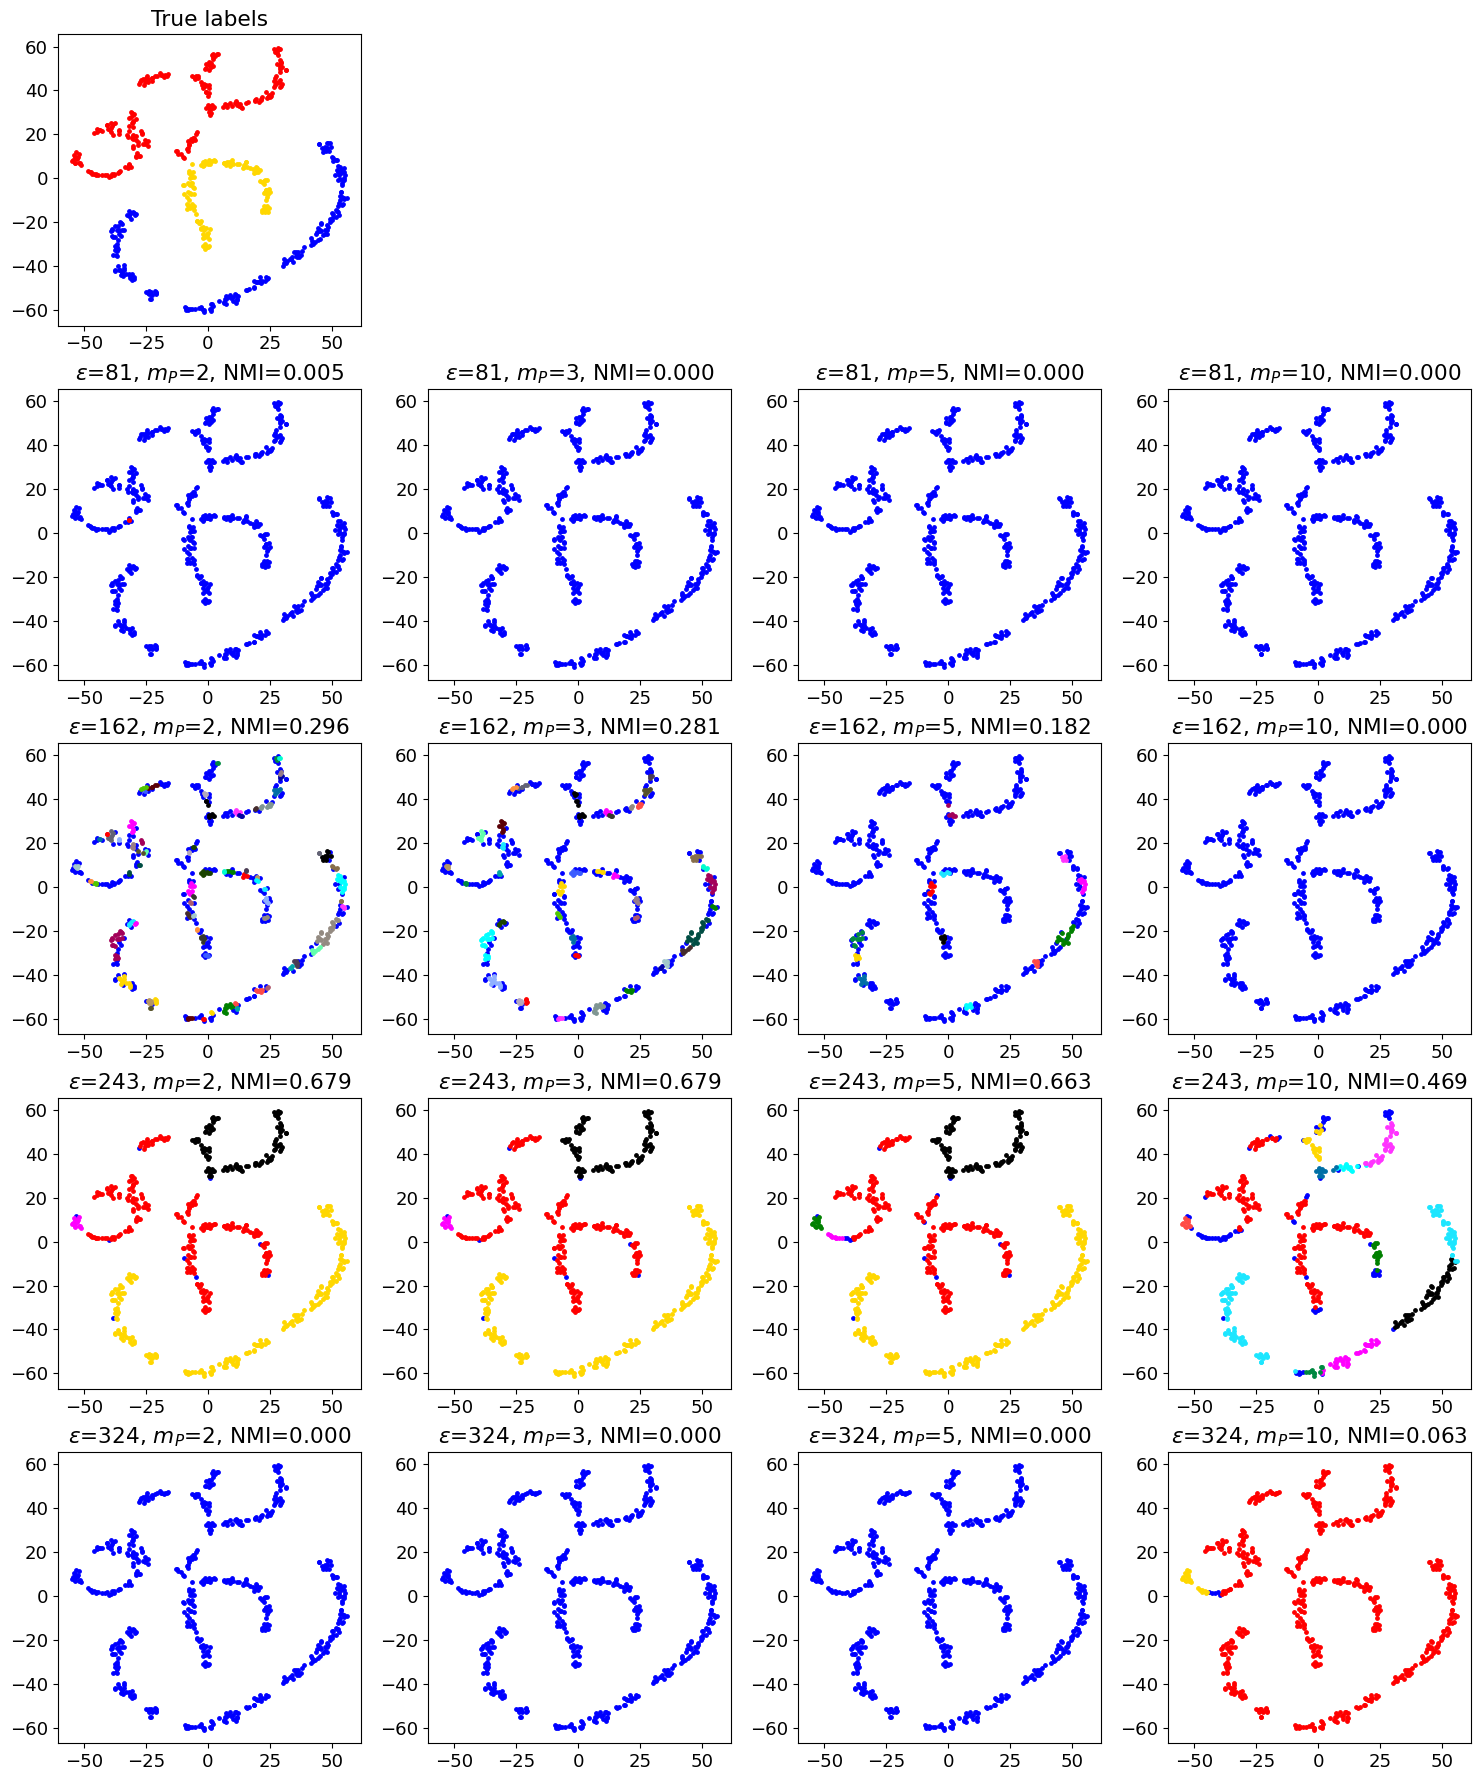

In [11]:
# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)

n_true_center=3
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X2D = X_all[2] # best(?) visualization above
X = data
y_true = y

#eps_range = [0.01,0.1,0.5,1.0,10.]
if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)

# varying epsilon
eps_range = [r/2,r,1.5*r,2*r]

# varying minimum number of samples in epsilon range
min_sample_range = [2,3,5,10]
DIMY=len(eps_range)
DIMX=len(min_sample_range)

# plot
fig, ax = plt.subplots(DIMY+1,DIMX,figsize=(15,18))

# plotting true labels
i,j=0,0
nmi=1
plotting_ax(X2D,y,ax[i,j])
ax[i,j].set_title('True labels')
for j in range(1,DIMX): fig.delaxes(ax[i,j])
    
# plotting with epsilon and min samples that vary
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        plotting_ax(X2D,y_hat,ax[i+1,j])
        nmi=NMI(y_true, y_hat)
        ax[i+1,j].set_title(r'$\epsilon$=%.0f, $m_P$=%i, NMI=%.3f'%(eps,min_samples,nmi))

plt.tight_layout(h_pad=0.5)
plt.show()

## 1. NMI heatmap

In [19]:
# number of nearest neighbors
nn = 100

# fitting the algorithm on our data
nbrs = NearestNeighbors(n_neighbors=nn+1).fit(x) #, algorithm='ball_tree'

# retrieving distances matrix for every point from every i-th neighbor
d, ind = nbrs.kneighbors(x)
# transposing the distances matrix
# note: dd[0] has a trivial set of zeros
dd=d.T

# Define eps and minsample range based on our data
eps_range = np.mean(dd,axis=1)[1:]
min_sample_range = [i for i in range(1,nn+1)]

#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X2D = X_all[2] # best(?) visualization above
X = data
y_true = y

DIMY=len(eps_range)
DIMX=len(min_sample_range)

i,j=0,0
nmi=1

hmap=np.ones((DIMX,DIMY)) #define default heatmap
    
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        nmi=NMI(y_hat, y_true)
        hmap[i,j]=nmi



Text(91.72222222222221, 0.5, 'eps')

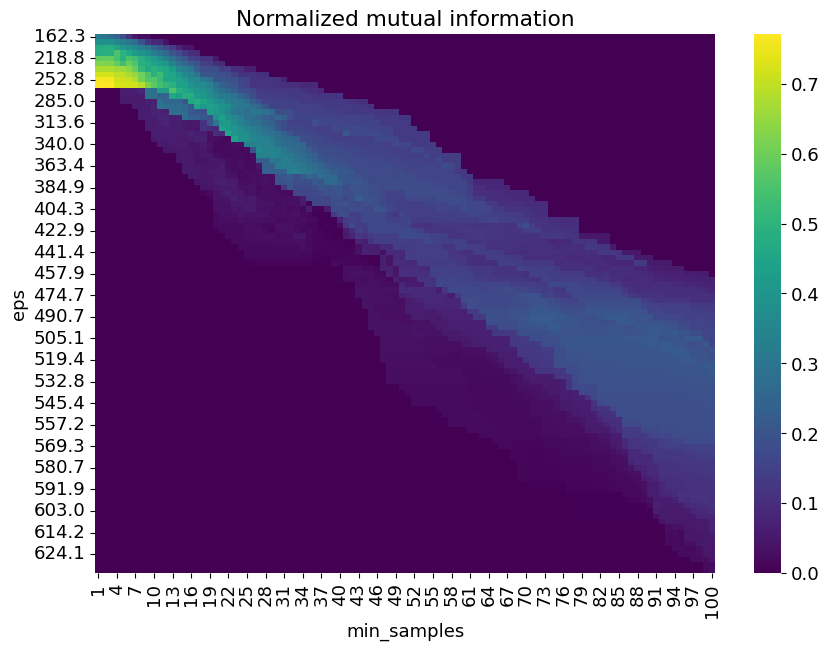

In [27]:
import seaborn as sns
import pandas as pd
htmap=pd.DataFrame(data=hmap,index=np.round(eps_range,1),columns=min_sample_range)
fig,ax=plt.subplots(figsize=(10,7))
ax.set_title("Normalized mutual information")
sns.heatmap(htmap,cmap="viridis")
plt.xlabel('min_samples')
plt.ylabel('eps')

# 2. PCA to understand 12-dim data

# 3. Compare different clustering methods

## 3.1 k-means clustering

## 3.2 Hierarchical clustering

# 4. Others visualization methods